In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pymc as pm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
howell_data = pd.read_csv("../data/Howell1.csv", sep=";")
howell_data.rename(columns={"male": "sex"}, inplace=True)
howell_data.head()

,height,weight,age,sex
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


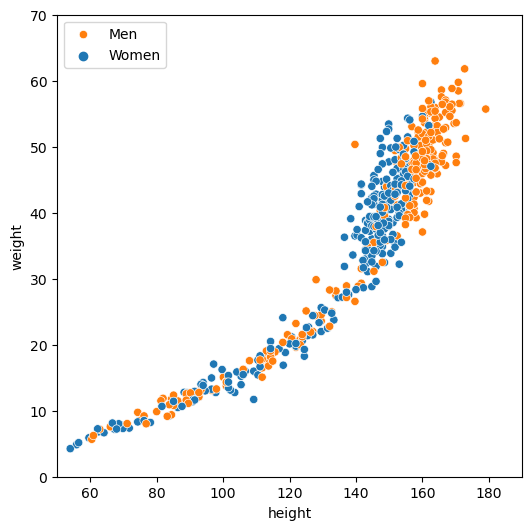

In [4]:
plt.figure(figsize=(6, 6))

sns.scatterplot(howell_data, x="height", y='weight', hue="sex")
plt.xlim(50, 190)
plt.ylim(0, 70)
plt.legend(labels=["Men", "Women"])
plt.show()

<img src="images/image45.jpeg" width="600" height="300" />

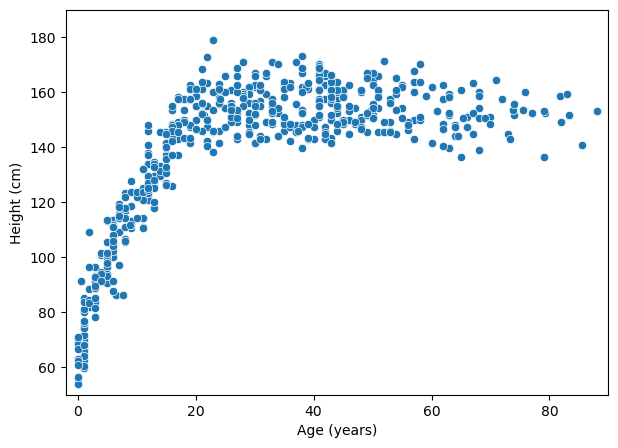

In [5]:
plt.figure(figsize=(7, 5))

sns.scatterplot(howell_data, x="age", y='height')
plt.xlim(-2, 90)
plt.ylim(50, 190)
plt.xlabel('Age (years)')
plt.ylabel('Height (cm)')
plt.show()

### Draw Splines

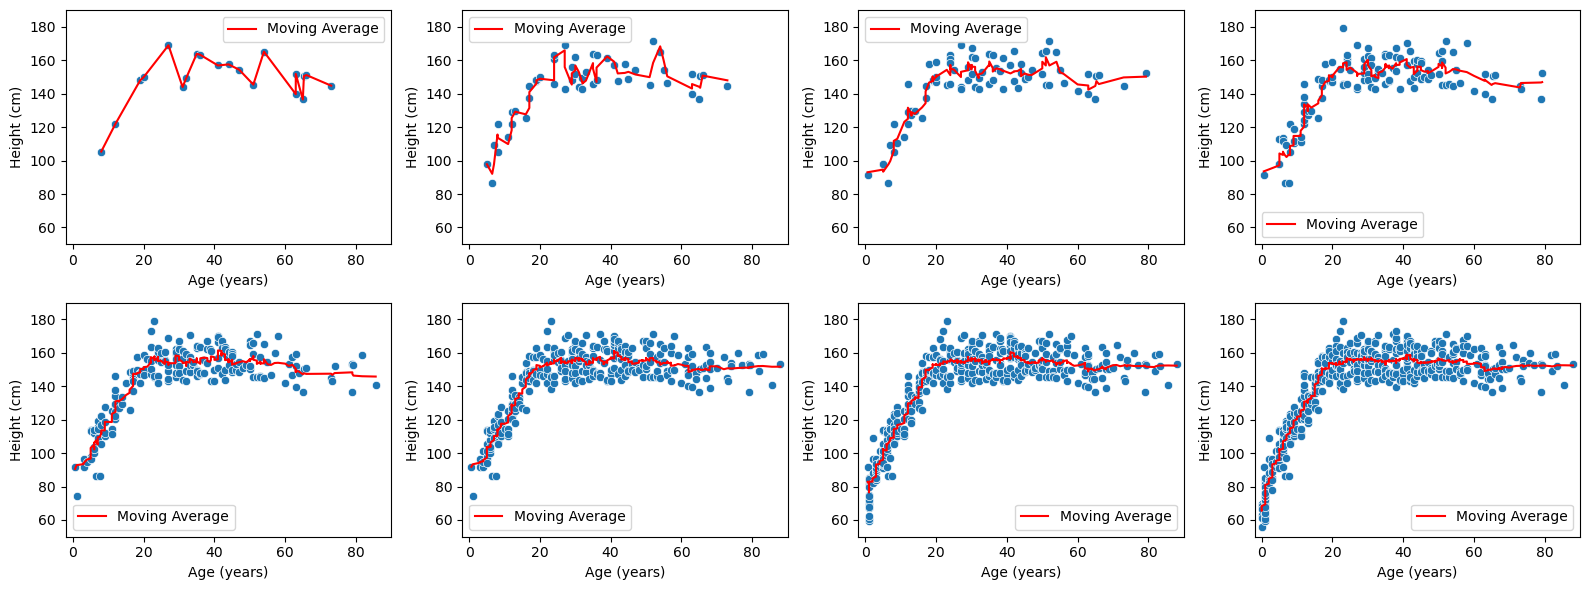

In [6]:
from scipy.ndimage import uniform_filter1d

# Assuming howell_data is already loaded and contains 'age' and 'height' columns

data_sizes = [20, 50, 80, 120, 200, 300, 400, 500]
fig, axs = plt.subplots(2, 4, figsize=(16, 6))

for d_size, ax in zip(data_sizes, axs.flatten()):
    local_data = howell_data[:d_size].sort_values(by='age').copy()
    
    sns.scatterplot(local_data, x="age", y='height', ax=ax)
    
    x = local_data['age'].values
    y = local_data['height'].values
    
    # Calculate moving averages
    y_moving_avg = uniform_filter1d(y, size=d_size//20, mode='nearest')
    
    # Plot the original data and moving average
    ax.plot(x, y_moving_avg, color='red', label='Moving Average')
    
    ax.set_xlim(-2, 90)
    ax.set_ylim(50, 190)
    ax.set_xlabel('Age (years)')
    ax.set_ylabel('Height (cm)')
    ax.legend()

plt.tight_layout()  
plt.show()

<img src="images/image50.jpeg" width="600" height="300" /> <img src="images/image49.jpeg" width="600" height="300" />

In [7]:
sub_data = howell_data.loc[howell_data["age"] >= 18].copy()

Weight = sub_data["weight"].values
Height = sub_data["height"].values
Sex = sub_data["sex"].values + 1
Hbar = sub_data["height"].mean()

with pm.Model() as model:
    # weight
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    a = pm.Normal('a', mu=60, sigma=10, shape=2)
    b = pm.Uniform('b', lower=0, upper=10, shape=2)
    mu = a[Sex-1] + b[Sex-1] * (Height - Hbar)
    
    # height
    tau = pm.Uniform('tau', lower=0, upper=10)
    h = pm.Normal('h', mu=160, sigma=10, shape=2)
    nu = h[Sex-1]
    
    # Likelihood
    W_obs = pm.Normal('W_obs', mu=mu, sigma=sigma, observed=Weight)
    
    # Priors for H
    H_obs = pm.Normal('H_obs', mu=nu, sigma=tau, observed=Height)
    
    trace1 = pm.sample(return_inferencedata=True, nuts_sampler="numpyro")
    
pm.summary(trace1).round(2)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],45.19,0.43,44.36,45.97,0.01,0.00,3521.0,3137.0,1.0
a[1],45.08,0.46,44.17,45.90,0.01,0.01,3095.0,2433.0,1.0
b[0],0.66,0.06,0.55,0.77,0.00,0.00,3841.0,2960.0,1.0
b[1],0.61,0.06,0.50,0.71,0.00,0.00,3244.0,2593.0,1.0
h[0],149.53,0.42,148.71,150.29,0.01,0.00,5106.0,2871.0,1.0
h[1],160.36,0.43,159.56,161.16,0.01,0.00,5359.0,2936.0,1.0
sigma,4.27,0.16,3.97,4.56,0.00,0.00,5588.0,3160.0,1.0
tau,5.56,0.21,5.17,5.96,0.00,0.00,5511.0,2920.0,1.0


In [8]:
post = trace1.posterior

p_a0 = post['a'][:, :, 0]
p_a1 = post['a'][:, :, 1]
p_b0 = post['b'][:, :, 0]
p_b1 = post['b'][:, :, 1]
p_h0 = post['h'][:, :, 0]
p_h1 = post['h'][:, :, 1]
p_sigma = post['sigma']
p_tau = post["tau"]

In [9]:
n = int(1e3)

# simulate w for s=0
H_S0 = np.random.normal(loc=p_h0, scale=p_tau, size=p_h0.shape)
W_S0 = np.random.normal(p_a0 + p_b0 * (H_S0 - Hbar), p_sigma, size=p_h0.shape)

# simulate w for s=1
H_S1 = np.random.normal(loc=p_h1, scale=p_tau, size=p_h1.shape)
W_S1 = np.random.normal(p_a1 + p_b1 * (H_S1 - Hbar), p_sigma, size=p_h1.shape)

W_S_diff = (W_S1 - W_S0).mean(axis=0)
W_S_df = pd.DataFrame({"W_S_diff": W_S_diff, "Sign": (W_S_diff >= 0).astype(int)})

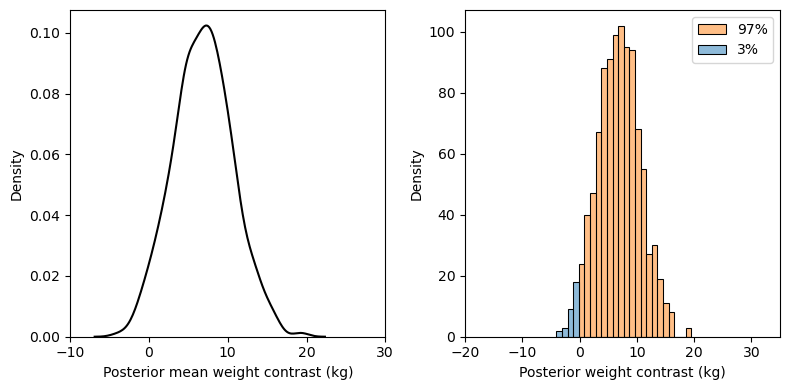

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

sns.kdeplot(data=W_S_diff, color="black", ax=axs[0])
axs[0].set_xlim(-10, 30)
axs[0].set_xlabel('Posterior mean weight contrast (kg)')
axs[0].set_ylabel('Density')

sns.histplot(data=W_S_df, x="W_S_diff", hue="Sign", ax=axs[1])
axs[1].set_xlim(-20, 35)
axs[1].set_xlabel('Posterior weight contrast (kg)')
axs[1].set_ylabel('Density')

pct = round((W_S_df["Sign"].sum() / len(W_S_df)) * 100)
axs[1].legend([f"{pct}%", f"{100 - pct}%"])

plt.tight_layout()
plt.show()

In [11]:
post_trace = trace1.posterior.to_dataframe().reset_index()
post_trace.head()

,chain,draw,a_dim_0,b_dim_0,h_dim_0,a,b,h,sigma,tau
0,0,0,0,0,0,46.096242,0.685263,149.802201,4.132789,5.616522
1,0,0,0,0,1,46.096242,0.685263,159.767055,4.132789,5.616522
2,0,0,0,1,0,46.096242,0.520023,149.802201,4.132789,5.616522
3,0,0,0,1,1,46.096242,0.520023,159.767055,4.132789,5.616522
4,0,0,1,0,0,45.640521,0.685263,149.802201,4.132789,5.616522


In [12]:
summary = pm.summary(trace1)["mean"]

sigma_mean = summary["sigma"]
tau_mean = summary["tau"]

a_women_mean = summary["a[0]"]
b_women_mean = summary["b[0]"]
h_women_mean = summary["h[0]"]

a_men_mean = summary["a[1]"]
b_men_mean = summary["b[1]"]
h_men_mean = summary["h[1]"]

In [13]:
# Still not sure about this part
n = int(1e4)

# simulate w for s=0
H_S0 = np.random.normal(loc=h_women_mean, scale=tau_mean, size=n)
W_S0 = np.random.normal(a_women_mean + b_women_mean * (H_S0 - Hbar), sigma_mean, size=n)

# simulate w for s=1
H_S1 = np.random.normal(loc=h_men_mean, scale=tau_mean, size=n)
W_S1 = np.random.normal(a_men_mean + b_men_mean * (H_S1 - Hbar), sigma_mean, size=n)

W_S_diff = W_S1 - W_S0
W_S_df = pd.DataFrame({"W_S_diff": W_S_diff, "Sign": (W_S_diff >= 0).astype(int)})

### Statistical Definition of Causal Effect of Sex on Weight:
#### The distribution (p) of weight (W) is conditional (|) on intervene (do) on S

<img src="images/image51.jpeg" width="700" height="400" />

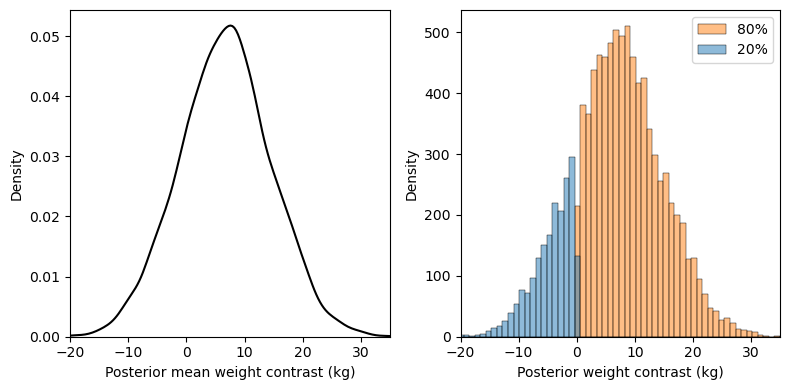

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

sns.kdeplot(data=W_S_diff, color="black", ax=axs[0])
axs[0].set_xlim(-20, 35)
axs[0].set_xlabel('Posterior mean weight contrast (kg)')
axs[0].set_ylabel('Density')

sns.histplot(data=W_S_df, x="W_S_diff", hue="Sign", ax=axs[1])
axs[1].set_xlim(-20, 35)
axs[1].set_xlabel('Posterior weight contrast (kg)')
axs[1].set_ylabel('Density')

pct = round((W_S_df["Sign"].sum() / len(W_S_df)) * 100)
axs[1].legend([f"{pct}%", f"{100 - pct}%"])

plt.tight_layout()
plt.show()

In [15]:
post_trace = trace1.posterior.to_dataframe().reset_index()

sigma = post_trace["sigma"]
tau = post_trace["tau"]

a_women = post_trace.loc[post_trace["a_dim_0"] == 0]
b_women = post_trace.loc[post_trace["b_dim_0"] == 0]
h_women = post_trace.loc[post_trace["h_dim_0"] == 0]

a_men = post_trace.loc[post_trace["a_dim_0"] == 1]
b_men = post_trace.loc[post_trace["b_dim_0"] == 1]
h_men = post_trace.loc[post_trace["h_dim_0"] == 1]